In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family = 'Malgun Gothic')

import scipy.stats
from scipy.stats import shapiro
from scipy.stats import bartlett, levene

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_broadcasting = pd.read_csv("C:/Users/tomy8/POSCOOOOOOOOO/빅데이터/조별프로젝트/code/Broad_Casting.csv")
df_crewgroup = pd.read_csv("C:/Users/tomy8/POSCOOOOOOOOO/빅데이터/조별프로젝트/code/Crew_group.csv")
df_product = pd.read_csv("C:/Users/tomy8/POSCOOOOOOOOO/빅데이터/조별프로젝트/code/Product.csv")

In [3]:
# 최종 데이터셋 구축
def model_data(df1,df2,df3):
    # data 병합
    df1['방송Code'] = df2['방송Code']
    
    방송1 = df1.loc[:,['방송Code','채널','소요분','가중분','방송구분','프로그램명']]
    방송2 = df2.loc[:,['PD','SH','TD']]
    방송12 = pd.concat([방송1, 방송2], axis=1)
    
    상품1 = df1.loc[:,~df1.columns.isin(['방송Code','채널','소요분','가중분','방송구분','프로그램명'])]
    상품2 = df2.loc[:,['MD담당자명','부서코드','부서명','협력사ID','협력사명']]
    상품12 = pd.concat([상품1, 상품2], axis=1)
    df_bc = pd.concat([방송12,상품12],axis=1)
    
    제품1 = df3.loc[:,['상품ID','브랜드명','대분류','중분류','소분류','세분류','카테고리']]
    df_total = pd.merge(제품1, df_bc, how='right', on='상품ID')
    
    # 이상치 변환
    df_total = df_total.replace({'상품방송순번':63},6)
    df_total = df_total.replace({'상품방송순번':12},2)
    df_total = df_total.replace({'ARS금액':2},0)
    df_total = df_total.replace({'ARS금액':2},0) 
    df_total = df_total.replace({'카테고리':'이미용_기타'},'이미용')
    
    for i in range(len(df_total)):
        if df_total['판매단가'][i] == 0:
            df_total['판매단가'][i] = df_total['상품주문금액'][i] / df_total['상품주문수량'][i]
        
    # 필요없는 열 제거
    df_total = df_total.drop(['소분류','세분류','채널','매입과세구분','협력사명','방송종료시간'], axis=1 ,inplace=False)
    
    # 필요없는 행 제거
    nodata1 = df_total[df_total['상품명'].str.contains('사용금지')].index
    df_total.drop(nodata1, inplace=True)
    nodata2 = df_total[df_total['상품명'].str.contains('미사용')].index
    df_total.drop(nodata2, inplace=True)    
    
    # 중복 행 제거
    df_total.drop_duplicates(['방송Code'] , keep='first', inplace=True, ignore_index=False)
    
    # 파생변수 생성
    df_total['Date'] = pd.to_datetime(df_total['방송시작시간'])
    df_total['year'] = df_total['Date'].dt.year
    df_total['month'] = df_total['Date'].dt.month
    df_total['day'] = df_total['Date'].dt.day
    df_total['hour'] = df_total['Date'].dt.hour
    df_total['weekday'] = df_total['Date'].dt.weekday
    df_total['yearmonth'] = df_total['Date'].dt.year.astype(str) + df_total['Date'].dt.month.astype(str)
    df_total = df_total.replace({'yearmonth':'20201'},'202001')
    df_total = df_total.replace({'yearmonth':'20202'},'202002')
    df_total = df_total.replace({'yearmonth':'20203'},'202003')
    df_total = df_total.replace({'yearmonth':'20204'},'202004')
    df_total = df_total.replace({'yearmonth':'20205'},'202005')
    df_total = df_total.replace({'yearmonth':'20206'},'202006')
    df_total = df_total.replace({'yearmonth':'20207'},'202007')
    df_total = df_total.replace({'yearmonth':'20208'},'202008')
    df_total = df_total.replace({'yearmonth':'20209'},'202009')
    
    df_total = df_total.replace({'yearmonth':'20211'},'202101')
    df_total = df_total.replace({'yearmonth':'20212'},'202102')
    df_total = df_total.replace({'yearmonth':'20213'},'202103')
    df_total = df_total.replace({'yearmonth':'20214'},'202104')
    df_total = df_total.replace({'yearmonth':'20215'},'202105')
    df_total = df_total.replace({'yearmonth':'20216'},'202106')
    df_total = df_total.replace({'yearmonth':'20217'},'202107')
    df_total = df_total.replace({'yearmonth':'20218'},'202108')
    df_total = df_total.replace({'yearmonth':'20219'},'202109')
    
    df_total = df_total.replace({'weekday':0},'월요일')
    df_total = df_total.replace({'weekday':1},'화요일')
    df_total = df_total.replace({'weekday':2},'수요일')
    df_total = df_total.replace({'weekday':3},'목요일')
    df_total = df_total.replace({'weekday':4},'금요일')
    df_total = df_total.replace({'weekday':5},'토요일')
    df_total = df_total.replace({'weekday':6},'일요일')
    
    df_total['상품가중치'] = df_total['상품가중분'] / df_total['상품소요분']
    df_total['홈쇼핑 수수료'] = df_total['판매단가'] * (df_total['수수료율'] / 100)
    df_total['최종주문수량'] = df_total['상품주문수량'] - df_total['상품취소수량']
    df_total['매출'] = df_total['홈쇼핑 수수료'] * df_total['최종주문수량']
    
    df_total['구매의사철회율'] = (df_total['상품취소수량'] / df_total['상품주문수량']) * 100
    df_total['구매의사철회율'] = df_total['구매의사철회율'].fillna(0)
    
    bins = [0,2,5,8,11,12]
    labels = ['winter','spring','summer','autumn','winter']
    df_total['season'] =  pd.cut(df_total['month'],bins, right=True,labels=labels,ordered=False)
    df_total.reset_index(drop=True,inplace=True)
    
    목표달성 = df_total[ df_total['상품목표주문금액'] < df_total['상품주문금액'] ]
    cate = df_total.groupby('카테고리')['방송Code'].count()
    MD1 = df_total.groupby(['MD담당자명','카테고리'],as_index=False)['방송Code'].count()
    MD2 = 목표달성.groupby(['MD담당자명','카테고리'],as_index=False)['방송Code'].count()
    MD = pd.merge(MD1, MD2, how='left', on=('MD담당자명','카테고리'))
    MD.fillna(0,inplace=True)
    MD.rename(columns={'방송Code_x':'총 방송 건수','방송Code_y':'목표 달성 건수'},inplace=True)
    MD = pd.merge(MD,cate, how='left', on=('카테고리'))
    MD.rename(columns={'방송Code':'카테고리 별 총 방송 건수'},inplace=True)
    MD['가중치'] = MD['총 방송 건수'] / MD['카테고리 별 총 방송 건수']
    MD['MD 역량'] = (MD['목표 달성 건수'] / MD['총 방송 건수']) * 100 * MD['가중치']
    MD.drop(['총 방송 건수','목표 달성 건수','카테고리 별 총 방송 건수','가중치'],axis=1, inplace=True)
    SH1 = df_total.groupby(['SH','카테고리'],as_index=False)['방송Code'].count()
    SH2 = 목표달성.groupby(['SH','카테고리'],as_index=False)['방송Code'].count()
    SH = pd.merge(SH1, SH2, how='left', on=('SH','카테고리'))
    SH.fillna(0,inplace=True)
    SH.rename(columns={'방송Code_x':'총 방송 건수','방송Code_y':'목표 달성 건수'},inplace=True)
    SH = pd.merge(SH,cate, how='left', on=('카테고리'))
    SH.rename(columns={'방송Code':'카테고리 별 총 방송 건수'},inplace=True)
    SH['가중치'] = SH['총 방송 건수'] / SH['카테고리 별 총 방송 건수']
    SH['SH 역량'] = (SH['목표 달성 건수'] / SH['총 방송 건수']) * 100  * SH['가중치']
    SH.drop(['총 방송 건수','목표 달성 건수','카테고리 별 총 방송 건수','가중치'],axis=1, inplace=True)
    PD1 = df_total.groupby(['PD','카테고리'],as_index=False)['방송Code'].count()
    PD2 = 목표달성.groupby(['PD','카테고리'],as_index=False)['방송Code'].count()
    PD = pd.merge(PD1, PD2, how='left', on=('PD','카테고리'))
    PD.fillna(0,inplace=True)
    PD.rename(columns={'방송Code_x':'총 방송 건수','방송Code_y':'목표 달성 건수'},inplace=True)
    PD = pd.merge(PD,cate, how='left', on=('카테고리'))
    PD.rename(columns={'방송Code':'카테고리 별 총 방송 건수'},inplace=True)
    PD['가중치'] = PD['총 방송 건수'] / PD['카테고리 별 총 방송 건수']
    PD['PD 역량'] = (PD['목표 달성 건수'] / PD['총 방송 건수']) * 100  * PD['가중치']
    PD.drop(['총 방송 건수','목표 달성 건수','카테고리 별 총 방송 건수','가중치'],axis=1, inplace=True)    
    TD1 = df_total.groupby(['TD','카테고리'],as_index=False)['방송Code'].count()
    TD2 = 목표달성.groupby(['TD','카테고리'],as_index=False)['방송Code'].count()
    TD = pd.merge(TD1, TD2, how='left', on=('TD','카테고리'))
    TD.fillna(0,inplace=True)
    TD.rename(columns={'방송Code_x':'총 방송 건수','방송Code_y':'목표 달성 건수'},inplace=True)
    TD = pd.merge(TD,cate, how='left', on=('카테고리'))
    TD.rename(columns={'방송Code':'카테고리 별 총 방송 건수'},inplace=True)
    TD['가중치'] = TD['총 방송 건수'] / TD['카테고리 별 총 방송 건수']
    TD['TD 역량'] = (TD['목표 달성 건수'] / TD['총 방송 건수']) * 100 * TD['가중치']
    TD.drop(['총 방송 건수','목표 달성 건수','카테고리 별 총 방송 건수','가중치'],axis=1, inplace=True)    
    df_total = pd.merge(df_total,PD, how='left',on=('PD','카테고리'))
    df_total = pd.merge(df_total,SH, how='left',on=('SH','카테고리'))
    df_total = pd.merge(df_total,TD, how='left',on=('TD','카테고리'))
    df_total = pd.merge(df_total,MD, how='left',on=('MD담당자명','카테고리'))
    df_total['제작진역량'] = df_total['PD 역량']*0.3 + df_total['SH 역량']*0.3 + df_total['TD 역량']*0.1 + df_total['MD 역량']*0.3
    
    final_df = df_total
    return final_df
    

In [4]:
df = model_data(df_broadcasting, df_crewgroup, df_product)

In [5]:
sort_df = df.sort_values(ascending=False,by='제작진역량')
yu_df = sort_df[sort_df['중분류'] != '무형상품']
mu_df = sort_df[sort_df['중분류'] == '무형상품']
yu_df = yu_df[['카테고리','상품명','PD','SH','TD','MD담당자명','제작진역량']]
mu_df = mu_df[['카테고리','상품명','PD','SH','TD','MD담당자명','제작진역량']]

In [6]:
df.drop(['상품ID','브랜드명','대분류','중분류','방송Code','소요분','가중분','프로그램명'],axis=1,inplace=True)
df.drop(['상품명','매입형태','배송방식','부서코드','협력사ID'],axis=1,inplace=True)

In [7]:
df.columns

Index(['카테고리', '방송구분', 'PD', 'SH', 'TD', '상품목표취급금액', '상품목표주문금액', '판매단가',
       '수수료율', '상품주문수량', '상품주문금액', '상품취소수량', '상품취소금액', 'ARS금액', '상품소요분',
       '상품가중분', '상품방송순번', '방송시작시간', 'MD담당자명', '부서명', 'Date', 'year', 'month',
       'day', 'hour', 'weekday', 'yearmonth', '상품가중치', '홈쇼핑 수수료', '최종주문수량',
       '매출', '구매의사철회율', 'season', 'PD 역량', 'SH 역량', 'TD 역량', 'MD 역량', '제작진역량'],
      dtype='object')

In [8]:
df_co = df.groupby(['yearmonth', '카테고리']).size()
df_co = pd.DataFrame(df_co)
df_co

0
yearmonth 카테고리    
202001    가공농산  52
          가공수산  29
          가공축산  50
          가전    29
          건강식품  84
...             ..
202111    이미용    5
          인테리어  29
          잡화    11
          주방용품  46
          침구    81

[512 rows x 1 columns]

In [9]:
df_co[0]

yearmonth  카테고리
202001     가공농산    52
           가공수산    29
           가공축산    50
           가전      29
           건강식품    84
                   ..
202111     이미용      5
           인테리어    29
           잡화      11
           주방용품    46
           침구      81
Name: 0, Length: 512, dtype: int64

In [10]:
df['카테고리']

0          의류
1        건강식품
2        건강식품
3        가공농산
4        신선수산
         ... 
26111      가전
26112      가전
26113      가전
26114    건강식품
26115    가공수산
Name: 카테고리, Length: 26116, dtype: object

In [11]:
df_year = df.groupby('yearmonth')['카테고리'].count()
df_year

yearmonth
202001    1140
202002    1061
202003    1156
202004    1090
202005    1112
202006    1064
202007    1098
202008    1175
202009    1057
202010    1179
202011    1127
202012    1131
202101    1089
202102    1030
202103    1158
202104    1213
202105    1249
202106    1188
202107    1323
202108    1329
202109    1282
202110    1329
202111     536
Name: 카테고리, dtype: int64

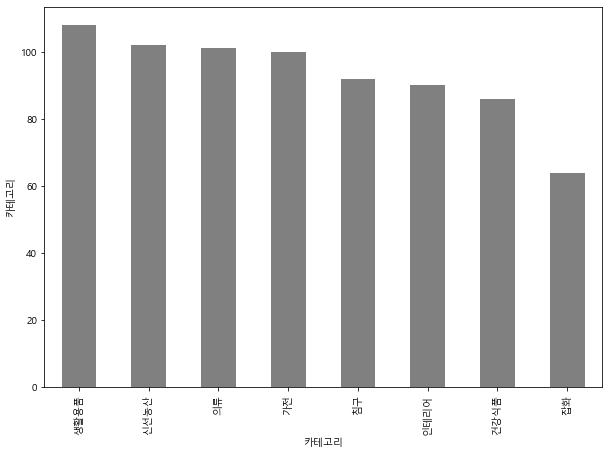

In [12]:
ex1 = df[df['yearmonth'] == '202010'].value_counts('카테고리')
ex1[ex1>60].plot.bar(figsize=(10,7),  color = ['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray'])
plt.ylabel('카테고리')
plt.savefig('202010.png')

In [55]:
df_pivot = df.pivot_table(index='season',columns='카테고리',values='매출')
season_order = ['spring','summer','autumn','winter']
df_pivot = df_pivot.loc[season_order]
df_pivot = df_pivot
df_pivot[['의류']].plot.bar(color = )

AttributeError: 'DataFrame' object has no attribute 'color'

In [68]:
df_pivot.info

<bound method DataFrame.info of 카테고리            가공농산          가공수산          가공축산            가전          건강식품  \
season                                                                         
spring  1.526639e+07  2.146166e+07  1.587233e+07  1.744187e+07  1.493767e+07   
summer  1.402468e+07  1.873887e+07  1.916888e+07  1.854230e+07  1.819010e+07   
autumn  1.515795e+07  2.007419e+07  2.104250e+07  1.663373e+07  1.985716e+07   
winter  1.397865e+07  2.079429e+07  1.962473e+07  1.887321e+07  1.592860e+07   

카테고리           레포츠기기         레포츠의류         문화서비스            보석        상생_공산품  \
season                                                                         
spring  2.039085e+07  1.311825e+07  1.691731e+07  7.195577e+06  1.513665e+06   
summer  1.592150e+07  1.290053e+07  1.984255e+07  6.248087e+06  2.326454e+06   
autumn  1.044734e+07  1.251819e+07  1.726365e+07  5.827063e+06  1.410174e+06   
winter  1.965154e+07  1.207038e+07  1.740220e+07  1.165085e+07  1.227990e+06   

카테고리  

ValueError: shape mismatch: objects cannot be broadcast to a single shape

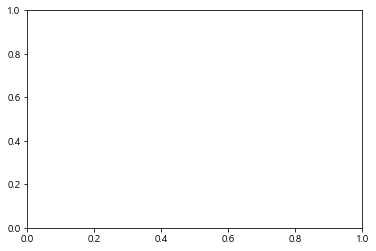

In [63]:
plt.bar(x = df_pivot[('의류')], height = df_pivot[('매출')])

<AxesSubplot:xlabel='season'>

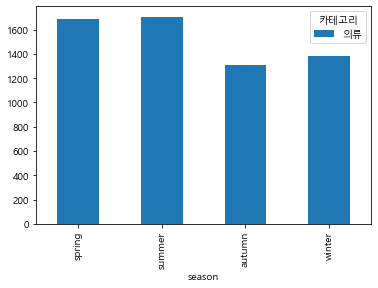

In [23]:
df_pivot = df.pivot_table(index='season',columns='카테고리',values='최종주문수량')
season_order = ['spring','summer','autumn','winter']
df_pivot = df_pivot.loc[season_order]
df_pivot[['의류']].plot.bar()

<AxesSubplot:xlabel='season'>

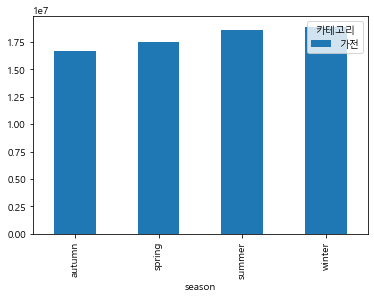

In [19]:
df_pivot = df.pivot_table(index='season',columns='카테고리',values='매출')
df_pivot[['가전']].plot.bar()

<AxesSubplot:xlabel='season'>

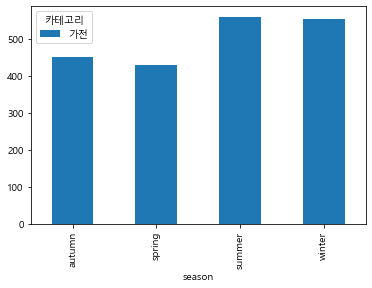

In [20]:
df_pivot = df.pivot_table(index='season',columns='카테고리',values='최종주문수량')
df_pivot[['가전']].plot.bar()

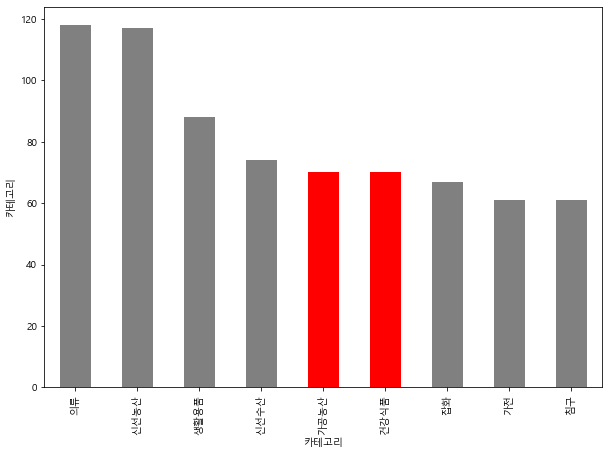

In [120]:
ex1 = df[df['yearmonth'] == '202012'].value_counts('카테고리')
ex1[ex1>60].plot.bar(figsize=(10,7),  color = ['gray', 'gray', 'gray', 'gray', 'red', 'red', 'gray', 'gray', 'gray'])
plt.ylabel('카테고리')
plt.savefig('202012.png')

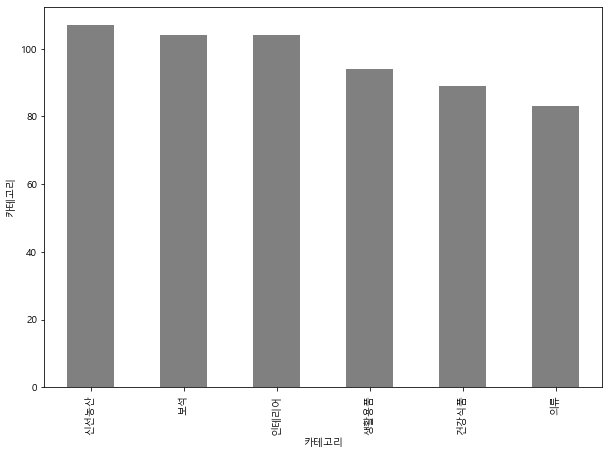

In [121]:
ex1 = df[df['yearmonth'] == '202104'].value_counts('카테고리')
ex1[ex1>80].plot.bar(figsize=(10,7) , color = ['gray', 'gray', 'gray', 'gray', 'gray', 'gray'])
plt.ylabel('카테고리')
plt.savefig('202104.png')

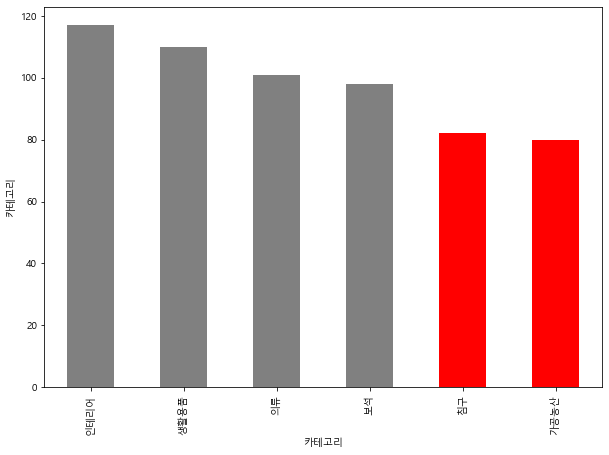

In [126]:
ex1 = df[df['yearmonth'] == '202105'].value_counts('카테고리')
ex1[ex1>79].plot.bar(figsize=(10,7), color = ['gray', 'gray', 'gray', 'gray', 'red', 'red'])
plt.ylabel('카테고리')
plt.savefig('202105.png')

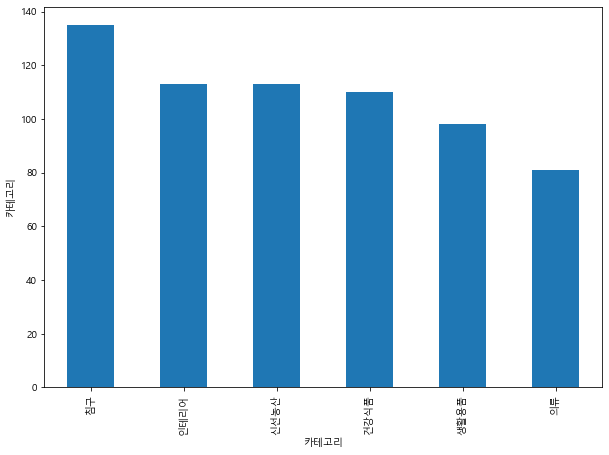

In [111]:
ex1 = df[df['yearmonth'] == '202109'].value_counts('카테고리')
ex1[ex1>80].plot.bar(figsize=(10,7),  color = ['gray', 'gray', 'gray', 'gray', 'red', 'red'])
plt.ylabel('카테고리')
plt.savefig('202109.png')

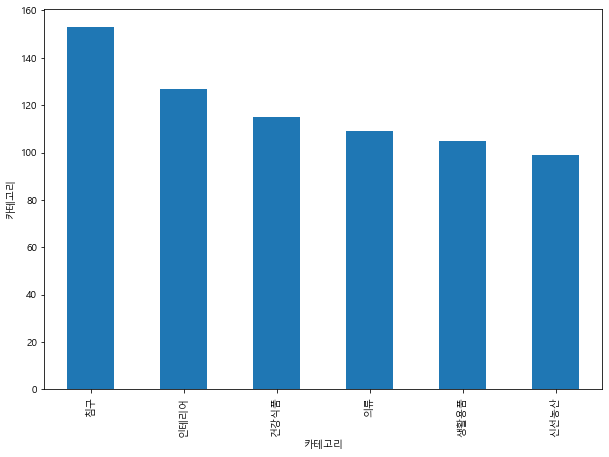

In [112]:
ex1 = df[df['yearmonth'] == '202110'].value_counts('카테고리')
ex1[ex1>80].plot.bar(figsize=(10,7),  color = ['gray', 'gray', 'gray', 'gray', 'red', 'red'])
plt.ylabel('카테고리')
plt.savefig('202110.png')

In [ ]:
df.to_csv("C:/Users/alstj/OneDrive/바탕 화면/total.csv",index=False, encoding='euc-kr')

In [101]:
df_ma = df.groupby(['season','카테고리','매출']).size()

season  카테고리  매출          
autumn  가공농산  0.000000e+00    1
              7.400800e+02    0
              9.950000e+02    0
              1.032000e+03    0
              1.440000e+03    0
                             ..
winter  침구    1.361978e+08    0
              1.400490e+08    0
              1.438450e+08    0
              1.551112e+08    0
              1.929165e+08    0
Length: 2017008, dtype: int64

In [144]:
df_sum

yearmonth
202001    1.765328e+10
202002    1.646001e+10
202003    1.656046e+10
202004    1.566425e+10
202005    1.698883e+10
202006    1.620838e+10
202007    1.529683e+10
202008    1.614349e+10
202009    1.517184e+10
202010    1.621385e+10
202011    1.549151e+10
202012    1.845786e+10
202101    1.789330e+10
202102    1.437599e+10
202103    1.566620e+10
202104    1.553185e+10
202105    1.543574e+10
202106    1.562034e+10
202107    1.678060e+10
202108    1.706106e+10
202109    1.816648e+10
202110    2.007096e+10
202111    8.656093e+09
Name: 매출, dtype: float64

In [177]:
df_sum = df.groupby('yearmonth')['매출'].sum()
i = 1
df_ratio = []
for i in range(len(df_sum)):
    

    a = (df_sum[i]/df_sum[i-1])
    df_ratio.append(a)
df_ratio.reverse()

In [179]:
df_ratio

[0.4312745531767613,
 1.1048349400710293,
 1.0647920616774202,
 1.0167131914395546,
 1.074278948472584,
 1.011959192309824,
 0.9938115828024876,
 0.9914244789717891,
 1.0897476977666778,
 0.8034286549089196,
 0.9694132725888636,
 1.1914827800072836,
 0.9554492674615183,
 1.0686803792825657,
 0.9398114738579224,
 1.0553485335845652,
 0.9437607482618637,
 0.9540609066950986,
 1.0845605532481823,
 0.9458828313302592,
 1.0061024067662727,
 0.9324053919288537,
 2.039405059589927]

In [193]:
df_list = pd.DataFrame(df_ratio, index =['2020_02','2020_03','2020_04','2020_05','2020_06','2020_07','2020_08','2020_09',
         '2020_10','2020_11','2020_12','2021_01','2021_02','2021_03','2021_04','2021_05','2021_06',
         '2021_07','2021_08','2021_09','2021_10','2021_11'])
df_list.plot.line()

ValueError: Shape of passed values is (23, 1), indices imply (21, 1)